<h1><center>Semi Supervised Semantic Segmentation: A Use Case</center></h1>
<h2><center>Universal Semi Supervised Semantic Segmentation (ICCV 2019)</center></h2>

<h3>What is semi-supervised learning in semantic segmentation</h3>


Semi supervised learning is a technique that incorporates the use of unlabeleled data which is available in plenty with a limited used of annotated data. Due to the fact that it uses limited labeled data, semi-supervised approach is a very important algorithm in the area of machine learning.


There are several techniques to perform semi-supervised learning as follows:

1) <b>Self-taught training</b>: Using clustering information to use the unlabeled data for classification
<img src="imgsuscv/stt.png">


2) <b>Co-training</b>: Use different sets of classifiers to classify the labeled data. Then use each classifier to label positive and negative examples and add this to the labeled set.

3) <b>Entropy regularization</b>: We also use entropy based metric to create a model using labeled data and add the unlabeled data whose entropy is minimum and then add the unlabeled data to the dataset. 
<img src="imgsuscv/entropy.png">

4) <b>Graph based </b>: In semi-supervised learning setting, the aim is to connect the labeled data with un-labeled data using density function.
<img src="imgsuscv/graph1.png">

<img src="imgsuscv/grpah2.png">


The images have been taken from [this](https://jhui.github.io/2017/01/15/Machine-learning-nonsupervised-and-semi-supervised-learning/) blog, you can refer this for more detailed information.




In the specific case of semantic segmentation, the task is the same that is to consider limited annotated data and majority non annotated data to increase the accuracy of the task. Researchers have used the above mentioned ideas in this specific sub area of Computer Vision.




In this notebook, we are going to have an overview of one of the latest approaches of semi-supervised semantic sgementation namely "<b>Universal Semi Supervised Semantic Segmentation</b>" which was accepted at <b>International Conference for Computer Vision</b> (ICCV 2019) last year. This notebook is aimed to explain the methodology used in this paper. 






<img src="imgsuscv/usss1.png">

Source of the image: [Slides](https://docs.google.com/presentation/d/e/2PACX-1vTX3J7YB_bjxkXPxcfMtlhlVMRPoyXcAPVyyYf8U8OmUwEbUwTvyNe7u4GkwabpCuo-5G293AbJlBsn/pub?start=false&loop=false&delayms=3000)

They introduce the concept of a single model that can be deployed in any domain for the task of semantic segmentation without affected by the <b>Domain shift</b> and <b>Appearance shift</b>. As can be seen from the figure, if we train a model on autonomous navigation based dataset like Cityscapes and deploy the trained model in a similar setting or in a total differnt domain, there is a loss of accuracy due to shift in the appearance of the objects. To address domain shift problem, they minimize supervised as well as within and cross-domain unsupervised losses, introducing a novel feature alignment objective basedon pixel-aware entropy  regularization. 

We are going to start the notebook and also discuss the concepts in between code snippets.


In this notebook, we are going to used two pixel level annotated datasets for autonomous navigation namely <b>[Cityscapes](https://www.cityscapes-dataset.com/)</b> and <b>[IDD](https://idd.insaan.iiit.ac.in/)</b>. They can be downloaded from these links. We will need atleast one gpu for running this experiment.

These two datasets are totally different in terms of geographical location, weather, traffic participants etc. but for them there label spaces overlap.


In [1]:
#First a bit of basic library imports

import os
import pdb
import time
import torch,sys
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from torch.optim import SGD, Adam, lr_scheduler
from torch.autograd import Variable
from torch.utils.data import DataLoader, ConcatDataset
import torchvision
import torch.nn.functional as F

In [3]:
from PIL import Image, ImageOps
from argparse import ArgumentParser
from EntropyLoss import EmbeddingLoss ##Entropy loss which is being used in the paper
from iouEval import iouEval
from dataset_loader import *
import transform as transforms
from transform import Colorize
from torchvision.transforms import ToPILImage

In [4]:
import importlib
from shutil import copyfile
from collections import OrderedDict , namedtuple

In [5]:
## Defining a global class for args to be used in the notebook

class global_args:
    model = 'drnet'
    basedir = '/ssd_scratch/cvit/amishra/'
    savedir = 'USCV11'
    num_epochs = 2
    batch_size = 2
    datasets = ['CS','IDD']
    alpha = 1
    beta = 1
    cuda = True
    em_dim = 100
    resume = False
    iouTrain = False
    iouVal = True
    start_epoch = 1
    bnsync = False
    state = False
    num_samples = 50
    num_workers = 2
    lr = 0.01
    steps_loss = 50
    resnet = 'resnet_18'
    epochs_save = 0
    finetune = True
    pt_em = False

args = global_args()

In [6]:
## defining the class for image transformations with all the paths for the datasets giving their sizes etc.

class load_data():

    def __init__(self, args):

        dinf = namedtuple('dinf' , ['name' , 'n_labels' , 'func' , 'path', 'size'])
        self.metadata = [dinf('IDD', 27, IDD_Dataset , 'idd' , (1024,512)),
                    dinf('CS' , 20 , CityscapesDataset , 'cityscapes' , (1024,512)),]

        self.num_labels = {entry.name:entry.n_labels for entry in self.metadata if entry.name in args.datasets}

        self.d_func = {entry.name:entry.func for entry in self.metadata}
        basedir = args.basedir
        self.d_path = {entry.name:basedir+entry.path for entry in self.metadata}

        self.d_size = {entry.name:entry.size for entry in self.metadata}

    def __call__(self, name, split='train', num_images=None, mode='labeled', file_path=False):

        transform = self.Img_transform(name, self.d_size[name] , split)
        return self.d_func[name](self.d_path[name] , split, transform, file_path, num_images , mode)

    def Img_transform(self, name, size, split='train'):


        assert (isinstance(size, tuple) and len(size)==2)

        if name in ['CS' , 'IDD']:

            if split=='train':
                t = [
                    transforms.Resize(size),
                    transforms.RandomCrop((512,512)), 
                    transforms.RandomHorizontalFlip(),
                    transforms.ToTensor()]
            else:
                t = [transforms.Resize(size),
                    transforms.ToTensor()]

            return transforms.Compose(t)

Load function gives the paths and helps in transforming the data. The train function defines training procedure.

We are going to use the <b>Dialated Residual Network</b> with the backbone architecture as Renet18. This type of architecture uses dialations in order to avoid downsampling and upsampling of the image. More details regarding this paper can be acquired from this [link](https://arxiv.org/abs/1705.09914).

<img src="imgsuscv/usss_pa.png">


This is the whole architecture of the Universal Semi Supervised Semantic Segmentation method is this. The supervised loss if computed using the shared encoder and decoders for each dataset. The shared encoder is then used for unlabeled examples to compute the similarity between the embedded representation of the encoder and the label embeddings of that dataset. See the pic below for more information.

<img src="imgsuscv/usss_shared_encoder.png">

From the above figure, it is clear that from encoder, we have traditional encoder layer which outputs the respective image in it's color spaces. Apart from this, we have entropy module that first maps the features of both the domains into a common D dimensional space, and then calculates similarity scores with the label embeddings of respective datasets.

In [7]:
def train(args, get_dataset, model, enc=False):
    best_acc = 0

    num_epochs = args.num_epochs


    n_gpus = torch.cuda.device_count()
    print("\nWorking with {} GPUs".format(n_gpus))

    datasets = args.datasets

    entropy = (args.alpha + args.beta) > 0
    if entropy:
        assert len(datasets) > 1 , "Entropy Module undefined with single dataset. Exiting ... "

    NUM_LABELS = get_dataset.num_labels

    
    ## Defining the dataset class for train, val and unlabeled data 

    dataset_train = {dname: get_dataset(dname, 'train', args.num_samples) for dname in datasets}
    dataset_val = {dname: get_dataset(dname, 'val',50) for dname in datasets}
    dataset_unlabeled = {dname: get_dataset(dname, 'train'  , mode='unlabeled') for dname in datasets}
    
    
    
    ## If entropy is defined then we can take the max of the unlabeled examples present
    if entropy:
        n_unlabeled = np.max([ len(dataset_unlabeled[dname]) for dname in datasets]) 
  

    print("Working with {} Dataset(s):".format(len(datasets)))
    for key in datasets:
        print("{}: Unlabeled images {}, Training on {} images, Validation on {} images".format(key , len(dataset_unlabeled[key]), len(dataset_train[key]) , len(dataset_val[key])))

        
        
    ## Defining the dataset paths, the images along with the labels    
    for d in datasets:
        if len(set(dataset_train.values())) != 1:
            max_train_size = np.max([ len(dataset_train[dname]) for dname in datasets]) 
            dataset_train[d].image_paths = dataset_train[d].image_paths*int(np.ceil(float(max_train_size)/len(dataset_train[d].image_paths)))
            dataset_train[d].label_paths = dataset_train[d].label_paths*int(np.ceil(float(max_train_size)/len(dataset_train[d].label_paths)))


    ## Defining dataloader for train and val splits         
            
            
    loader_train = {dname:DataLoader(dataset_train[dname], num_workers=args.num_workers, batch_size=args.batch_size, 
                            shuffle=True) for dname in datasets}
    loader_val = {dname:DataLoader(dataset_val[dname], num_workers=args.num_workers, batch_size=2, 
                        shuffle=True, drop_last=True) for dname in datasets}

   ## If multiple datasets are being used and entropy is enabled, then we define the dataloader class for unlabeled 
   ## examples. We will not consider the label map of these samples

    if entropy:
        loader_unlabeled = {dname:DataLoader(dataset_unlabeled[dname], num_workers=args.num_workers, batch_size=args.batch_size, 
                                shuffle=True, drop_last=True) for dname in datasets}
 

    savedir = f'/ssd_scratch/cvit/amishra/{args.savedir}'

    
    
    ## DRNET model: Dialated Residual network
    if args.model == 'drnet':
        optimizer = SGD(model.optim_parameters(), args.lr, 0.9,  weight_decay=1e-4)     ## scheduler DR-Net
    if args.cuda:
        model = torch.nn.DataParallel(model).cuda()
        
        

    ## Defining some other necessary data types for training
        
    doIou = {'train':args.iouTrain , 'val':args.iouVal}
    le_file = savedir + '/label_embedding.pt'  
    average_epoch_loss = {'train':np.inf , 'val':np.inf}
    
    ## Label embedding which is a key aspect in unsupervised loss computation. We embed the labels to some 100 dimensional
    ## space 

    label_embedding = {key:torch.randn(NUM_LABELS[key] , args.em_dim).cuda() for key in datasets} ## Random Initialization
    

    start_epoch = 1
    
    
    ## If resume, then we load the checkpoint with all the basic information
    
    
    if args.resume:
        if enc:
            filenameCheckpoint = savedir + '/checkpoint_enc.pth.tar'
        else:
            filenameCheckpoint = savedir + '/checkpoint.pth.tar'

        assert os.path.exists(filenameCheckpoint), "Error: resume option was used but checkpoint was not found in folder"
        checkpoint = torch.load(filenameCheckpoint)
        start_epoch = checkpoint['epoch']
        model.load_state_dict(checkpoint['state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer'])
        best_acc = checkpoint['best_acc']
        label_embedding = torch.load(le_file) if len(datasets) >1 else None
        print("=> Loaded checkpoint at epoch {}".format(checkpoint['epoch']))


    scheduler = lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda epoch: pow((1-((epoch-1)/args.num_epochs)),0.9))  ## scheduler 2
    loss_criterion = {key:torch.nn.CrossEntropyLoss(ignore_index=NUM_LABELS[key]-1).cuda() for key in datasets}

    
    ## If more than one dataset is given, then we define an embedding loss which takes the labels of the dataset,
    ## the embedding dimension, the label embedding and the loss critertion which 2D Cross Entropy.
    
    ## We calculate the similarity within the dataset and across the dataset by calculating the similarity vectors between the
    ## embedded encoder representation and the embedding representation of the label of the dataset. Refer more in the code of embeddingloss.py 
    
    if len(datasets)>1:
        similarity_module = EmbeddingLoss(NUM_LABELS, args.em_dim, label_embedding, loss_criterion)
        similarity_module = torch.nn.DataParallel(similarity_module).cuda()
        torch.save(label_embedding , le_file)

    print()
    print("========== STARTING TRAINING ===========")
    print()

    n_iters1 = [len(loader_train[d]) for d in datasets]
    n_iters = min(n_iters1)

    if entropy:
        unlabeled_iters = {d:len(loader_unlabeled[d])//n_iters for d in datasets}


    for epoch in range(start_epoch, num_epochs+1):

        epoch_start_time = time.time()
        usedLr = 0
        iou = {key:(0,0) for key in datasets}

        ###### TRAIN begins  #################
        for phase in ['train']:

            eval_iou = doIou[phase]
            print("-----", phase ,"- EPOCH", epoch, "-----")

            scheduler.step(epoch)    
            model.train()

            for param_group in optimizer.param_groups:
                print("LEARNING RATE: " , param_group['lr'])
                usedLr = float(param_group['lr'])

            ## Initialize the iterables

            labeled_iterator = {dname:iter(loader_train[dname]) for dname in datasets}

            if entropy:
                unlabeled_iterator = {dname:iter(loader_unlabeled[dname]) for dname in datasets}

            if args.alpha:
                alpha = 1
            if args.beta:
                beta = 1

            epoch_loss = {d:[] for d in datasets}
            epoch_sup_loss = {d:[] for d in datasets}
            epoch_ent_loss = {d:[] for d in datasets}

            time_taken = []    

            if (eval_iou):
                iou_data = {key:iouEval(NUM_LABELS[key]) for key in datasets}

            for itr in range(n_iters):

                optimizer.zero_grad()
                loss_sup = {d:0 for d in datasets}
                loss_ent = {d:[0] for d in datasets}

                for d in datasets:


                    images_l , targets_l = next(labeled_iterator[d])

                    images_l = images_l.cuda()
                    targets_l = targets_l.cuda()

                    start_time = time.time()

                    dec_outputs = model(images_l , enc=False, finetune=args.finetune) 
                    
                    ## For each dataset the output is calculated and the loss is backpropagated

                    loss_s = loss_criterion[d](dec_outputs[d] , targets_l.squeeze(1))
                    loss_s.backward()

                    loss_sup[d] = loss_s.item() 
                    
                    ##NOTE: This supervised loss is calculated using shared encoder and different decoders 
                    ## are employed for the different datasets and the invidual supervised loss for the dataset
                    ## is appended in the dictionary key value for that particular dataset.
                    

                    if entropy:
                    
                    ## Here is how we calculate the unsupervised loss
                    
                    ## As stated above, this similarity module is used to calculate the unsupervised loss by computing 
                    ## distance in the embedded representation.  

                        for _ in range(unlabeled_iters[d]):
                            images_u = next(unlabeled_iterator[d])
                            images_u = images_u.cuda()

                            _ , en_outputs = model(images_u)
                            loss_e = torch.mean(similarity_module(en_outputs, d, args.alpha, args.beta)) ## unsupervised losses
                            loss_e /= unlabeled_iters[d]
                            loss_e.backward()
                            loss_ent[d].append(loss_e.item())
                        epoch_sup_loss[d].append(loss_sup[d])
                        epoch_ent_loss[d].extend(loss_ent[d])
                        epoch_loss[d].append(loss_sup[d] + np.sum(loss_ent[d])) ## Already averaged over iters

                time_taken.append(time.time() - start_time)
                optimizer.step()

                ## Printing the training statistics
                
                
                if args.steps_loss > 0 and (itr % args.steps_loss == 0 or itr == n_iters-1):
                    average = {d:np.around(sum(epoch_loss[d]) / len(epoch_loss[d]) , 3) for d in datasets}
                    print(f'{phase} loss: {average} (epoch: {epoch}, step: {itr})', 
                            "// Avg time/img: %.4f s" % (sum(time_taken) / len(time_taken) / args.batch_size))   


                average = {d:np.mean(epoch_loss[d]) for d in datasets}	
                average_epoch_loss[phase] = sum(average.values())

                if entropy:
                    average_epoch_sup_loss = {d:np.mean(epoch_sup_loss[d]) for d in datasets}
                    average_epoch_ent_loss = {d:np.mean(epoch_ent_loss[d]) for d in datasets}


            ## Todo: A better way to close the worker threads.
            for d in datasets:
                while True:
                    try:
                        _ =  next(labeled_iterator[d])
                    except StopIteration:
                        break;

                if entropy:
                    while True: 
                        try:
                            _ =  next(unlabeled_iterator[d])
                        except StopIteration:
                            break;

            iou = {key:(0,0) for key in datasets}

            if (eval_iou):
                iou = {key:iou_data[key].getIoU() for key in datasets}

                iouStr_label = {key : '{:0.2f}'.format(iou[key][0]*100) for key in datasets}
                for d in datasets:
                    print ("EPOCH IoU on {} dataset: {} %".format(d , iouStr_label[d]))

        ########## Train ends ###############################

        
        
        
        ##### Validation ###############
        
        if (epoch == 1) or (epoch%5==0): ## validation after every 5 epoch
            for phase in ['val']:

                eval_iou = doIou[phase]
                print("-----", phase ,"- EPOCH", epoch, "-----")

                model.eval()

                if (eval_iou):
                    iou_data = {d:iouEval(NUM_LABELS[d]) for d in datasets}

                epoch_val_loss = {d:[] for d in datasets}

                for d in datasets:
                    time_taken = []    

                    for itr, (images, targets) in enumerate(loader_val[d]):

                        start_time = time.time()

                        images = images.cuda()
                        targets = targets.cuda()
                        
                        ## During val, we just find the argmax of the output and in the next cell visualize the output

                        with torch.set_grad_enabled(False):

                            seg_output = model(images, enc=False)
                            loss = loss_criterion[d](seg_output[d], targets.squeeze(1))


                            if eval_iou:
                                pred = seg_output[d].argmax(1,True).data
                                iou_data[d].addBatch( pred , targets.data)

                            epoch_val_loss[d].append(loss.item())

                        time_taken.append(time.time() - start_time)

                        if args.steps_loss > 0 and (itr % args.steps_loss == 0 or itr == len(loader_val[d])-1):
                            average = np.around(np.mean(epoch_val_loss[d]) , 3)
                            print(f'{d}: {phase} loss: {average} (epoch: {epoch}, step: {itr})', 
                                    "// Avg time/img: %.4f s" % (sum(time_taken) / len(time_taken) / args.batch_size)) 


                average_epoch_loss[phase] = np.sum([np.mean(epoch_val_loss[d]) for d in datasets])

                if (eval_iou):
                    iou = {d:iou_data[d].getIoU() for d in datasets}

                    iouStr_label = {d : '{:0.2f}'.format(iou[d][0]*100) for d in datasets}
                    for d in datasets:
                        print ("EPOCH IoU on {} dataset: {} %".format(d , iouStr_label[d]))
#                         if args.pAcc:
#                             print(f'{d}: pAcc : {np.mean(pAcc[d])*100}%')
        ############# VALIDATION ends #######################


        print("Epoch time {} s".format(time.time() - epoch_start_time))
        
        ## We also save the best model which gives us the highest IOU in the validation process

        # remember best valIoU and save checkpoint
        if sum([iou[key][0] for key in datasets]) == 0:
            current_acc = -average_epoch_loss['val']
        else:
            current_acc = sum([iou[key][0] for key in datasets])/len(datasets) ## Average of the IoUs to save best model

        is_best = current_acc > best_acc
        best_acc = max(current_acc, best_acc)

        filenameCheckpoint = savedir + '/checkpoint.pth.tar'
        filenameBest = savedir + '/model_best.pth.tar'

        save_checkpoint({
            'epoch': epoch + 1,
            'arch': str(model),
            'state_dict': model.state_dict(),
            'best_acc': best_acc,
            'optimizer' : optimizer.state_dict(),
        }, is_best, filenameCheckpoint, filenameBest)



    return(model, loader_val, loss_criterion)   

def save_checkpoint(state, is_best, filenameCheckpoint, filenameBest):
    torch.save(state, filenameCheckpoint)
    if is_best:
        print ("Saving model as best")
        torch.save(state, filenameBest)



In [8]:
## Main function to start the process of training, load the model if args.state is given.


def main(args, get_dataset):
    
    savedir = f'/ssd_scratch/cvit/amishra/{args.savedir}'

    if os.path.exists(savedir + '/model_best.pth') and not args.resume and not args.finetune:
        print("Save directory already exists ... ")
        sys.exit(0)

    if not os.path.exists(savedir):
        os.makedirs(savedir)

    #Load Model
    assert os.path.exists(args.model + ".py"), f"Error: model definition for {args.model} not found"

    model_file = importlib.import_module(args.model)
    if args.bnsync:
        model_file.BatchNorm = batchnormsync.BatchNormSync
    else:
        model_file.BatchNorm = torch.nn.BatchNorm2d


    NUM_LABELS = get_dataset.num_labels

    model = model_file.Net(NUM_LABELS , args.em_dim , args.resnet)		
    copyfile(args.model + ".py", savedir + '/' + args.model + ".py")

    if args.state:

        def load_my_state_dict(model, state_dict):  #custom function to load model when not all dict keys are there
            own_state = model.state_dict()
            state_dict = {k.partition('module.')[2]: v for k,v in state_dict.items()}
            for name, param in state_dict.items():

                if name.startswith(('seg' , 'up' , 'en_map' , 'en_up')):
                    continue
                elif name not in own_state:
                    print("Not loading {}".format(name))
                    continue
                own_state[name].copy_(param)

            print("Loaded pretrained model ... ")
            return model


        state_dict = torch.load(args.state)
        model = load_my_state_dict(model, state_dict)


    train_start = time.time()

    model, loader_val, loss_criterion = train(args, get_dataset, model, False)   #Train 
    print("========== TRAINING FINISHED ===========")
    print(f"Took {(time.time()-train_start)/60} minutes")
    return model, loader_val, loss_criterion

In [9]:
## Returned model, val loader for visualization process

get_dataset = load_data(args)
model, loader_val, loss_crit = main(args, get_dataset)


Working with 2 GPUs
Working with 2 Dataset(s):
CS: Unlabeled images 500, Training on 50 images, Validation on 50 images
IDD: Unlabeled images 500, Training on 50 images, Validation on 50 images

========== STARTING TRAINING ===========

----- train - EPOCH 1 -----
LEARNING RATE:  0.01


/home/ashutosh.mishra/miniconda3/envs/pytorch/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:122: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


train loss: {'CS': 19.846, 'IDD': 26.605} (epoch: 1, step: 0) // Avg time/img: 2.8832 s
train loss: {'CS': 8.875, 'IDD': 11.961} (epoch: 1, step: 24) // Avg time/img: 3.6607 s
----- val - EPOCH 1 -----
CS: val loss: 10.316 (epoch: 1, step: 0) // Avg time/img: 0.1850 s
CS: val loss: 8.114 (epoch: 1, step: 24) // Avg time/img: 0.1786 s
IDD: val loss: 8.922 (epoch: 1, step: 0) // Avg time/img: 0.2288 s
IDD: val loss: 8.756 (epoch: 1, step: 24) // Avg time/img: 0.1977 s
EPOCH IoU on CS dataset: 9.33 %
EPOCH IoU on IDD dataset: 7.16 %
Epoch time 386.9113349914551 s
Saving model as best
----- train - EPOCH 2 -----
LEARNING RATE:  0.005358867312681466
train loss: {'CS': 4.429, 'IDD': 8.265} (epoch: 2, step: 0) // Avg time/img: 4.0580 s
train loss: {'CS': 3.599, 'IDD': 4.876} (epoch: 2, step: 24) // Avg time/img: 3.7050 s
Epoch time 373.6139979362488 s
========== TRAINING FINISHED ===========
Took 12.732773236433665 minutes


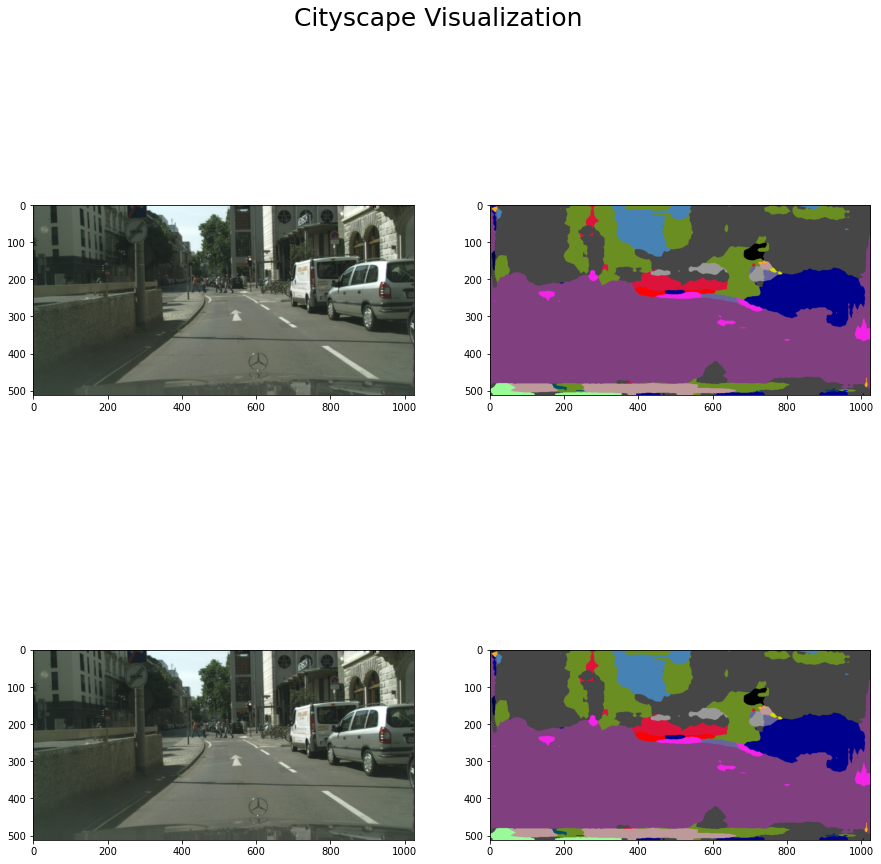

In [10]:
dataiter = iter(loader_val[args.datasets[0]])
images, labels = dataiter.next()


with torch.no_grad():
    outputs = model(images, enc=False)

pred = outputs[args.datasets[0]].argmax(1,True).data    


f, axarr = plt.subplots(2,2, figsize=(15,15))
axarr[0,0].imshow(ToPILImage()(images[0].cpu()))
axarr[0,1].imshow(ToPILImage()(Colorize()(pred[0].cpu())))
axarr[1,0].imshow(ToPILImage()(images[0].cpu()))
axarr[1,1].imshow(ToPILImage()(Colorize()(pred[0].cpu())))
f.suptitle('Cityscape Visualization',fontsize=25)
plt.show()